HW1 solution
======

## Behavioural cloning

TODO:
----
1. generate rollouts
This are sequences of the type expertSequence#1 = {s0 -> a0, s1 -> a1, s2 -> a3} done with the expert policy
<br>

- expert_data/something.pkl
- big number -> 18101
- observations.shape = (big number, 44)
- actions.shape = (big number, 17)
- returns.shape = (20, )
<br>
----
2. implement behavioural cloning
implement a neural net of the sort F(s) = a trained on all the expertSequence. Then create a policy using the neural net

In [1]:
import pickle as pk

In [2]:
expert_rollouts = pk.load(open("expert_data/RoboschoolHumanoid-v1.pkl","rb"))

In [3]:
expert_rollouts

{'observations': array([[ 2.3841858e-08,  9.6519969e-02,  9.9533105e-01, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [-2.0956160e-03,  8.6720474e-02,  9.9623269e-01, ...,
         -7.4585444e-01,  0.0000000e+00,  0.0000000e+00],
        [-9.7385403e-03,  4.9320240e-02,  9.9878299e-01, ...,
         -5.6518716e-01,  0.0000000e+00,  0.0000000e+00],
        ...,
        [-5.6102455e-01, -9.6735783e-02,  9.9531007e-01, ...,
          1.3878012e-01,  0.0000000e+00,  1.0000000e+00],
        [-5.7833594e-01,  3.6169939e-02,  9.9934566e-01, ...,
          4.0903750e-01,  0.0000000e+00,  1.0000000e+00],
        [-6.0214376e-01,  1.6259982e-01,  9.8669207e-01, ...,
         -2.3979065e-01,  0.0000000e+00,  1.0000000e+00]], dtype=float32),
 'actions': array([[-0.9874024 ,  0.83883409,  0.85504517, ..., -0.80231142,
          0.38560634, -0.42560914],
        [-0.21825224,  0.33224376,  0.18650389, ..., -1.34010936,
         -0.75379524,  0.3031881 ],
        [-0.304975 

In [4]:
expert_rollouts['observations'].shape

(1361450, 44)

In [5]:
expert_rollouts['actions'].shape

(1361450, 17)

In [6]:
expert_rollouts['returns'].shape

(1500,)

In [7]:
inputs = expert_rollouts['observations']
outputs = expert_rollouts['actions']

In [8]:
assert len(inputs) == len(outputs)

In [9]:
split = int(len(inputs)*0.8)
print(split)

1089160


In [10]:
X_train, y_train = inputs[:split], outputs[:split]
X_test, y_test = inputs[split:], outputs[split:]

model
========

In [11]:
import tensorflow as tf
import numpy as np

In [12]:
def tf_reset():
    try:
        sess.close()
    except:
        pass
    tf.reset_default_graph()
    return tf.Session()

In [13]:
sess = tf_reset()
def create_model():
    input_ph = tf.placeholder(dtype=tf.float32, shape=[None, 44]) # [None, 1] is because is 1D array
    output_ph = tf.placeholder(dtype=tf.float32, shape=[None, 17])
    
    W0 = tf.get_variable(name='W0', shape=[44, 30], initializer = tf.contrib.layers.variance_scaling_initializer())
    W1 = tf.get_variable(name='W1', shape=[30, 23], initializer = tf.contrib.layers.variance_scaling_initializer())
    W2 = tf.get_variable(name='W2', shape=[23, 17], initializer = tf.contrib.layers.variance_scaling_initializer())
    
    
    b0 = tf.get_variable(name='b0', shape=[30], initializer = tf.constant_initializer(0))
    b1 = tf.get_variable(name='b1', shape=[23], initializer = tf.constant_initializer(0))
    b2 = tf.get_variable(name='b2', shape=[17], initializer = tf.constant_initializer(0))
    
    weights = [W0, W1, W2]
    biases = [b0, b1, b2]
    activations = [tf.nn.relu, tf.nn.relu, None]
    
    layer = input_ph
    for W, b, activation in zip(weights, biases, activations):
        layer = tf.matmul(layer, W) + b
        if activation is not None:
            layer = activation(layer)
            
    output_pred = layer
    return input_ph, output_ph, output_pred

In [14]:
input_ph, output_ph, output_pred = create_model()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.


In [15]:

mse = tf.reduce_mean(0.5 * tf.square(output_pred - output_ph)) # this is the mean square error
opt = tf.train.AdamOptimizer().minimize(mse) # this is an operation that pereform gradient descent

In [16]:

sess.run(tf.global_variables_initializer())
saver = tf.train.Saver() # save weight as the training goes on

In [17]:
#training
batch_size = 32
training_mse = []
for training_step in range(15000):
    #random batch
    indices = np.random.randint(low = 0, high = len(X_train), size = batch_size)
    input_batch = X_train[indices]
    output_batch = y_train[indices]
    
    # run optimizer and get mse
    _, mse_run = sess.run([opt, mse], feed_dict={input_ph: input_batch, output_ph: output_batch})
    
    training_mse.append(mse_run)
    if training_step % 1000 == 0:
        print('{0:04d} mse : {1:.3f}'.format(training_step, mse_run))
        saver.save(sess, '/tmp/model.ckpt')

0000 mse : 0.263
1000 mse : 0.035
2000 mse : 0.039
3000 mse : 0.035
4000 mse : 0.042
5000 mse : 0.027
6000 mse : 0.030
7000 mse : 0.017
8000 mse : 0.022
9000 mse : 0.016
10000 mse : 0.019
11000 mse : 0.018
12000 mse : 0.070
13000 mse : 0.016
14000 mse : 0.026


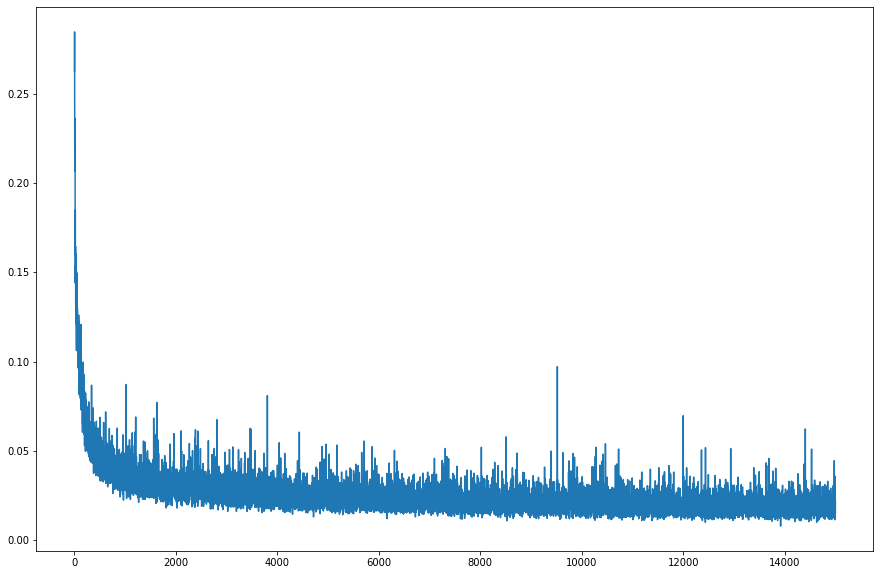

In [34]:
from matplotlib import pyplot as plt
plt.figure(figsize=(15,10))
plt.plot(training_mse)
plt.show()

In [19]:
sess = tf_reset()

input_ph, output_ph, output_pred = create_model()
saver = tf.train.Saver() 
saver.restore(sess, "/tmp/model.ckpt")

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /tmp/model.ckpt


In [20]:
# validation score was 0.03

In [21]:
# prediction of only one action
output_pred_run = sess.run(output_pred, feed_dict={input_ph: X_test[0].reshape((1,44))})

In [22]:
output_pred_run

array([[-0.39005423,  0.42127615, -0.08623004,  0.45420158,  1.0112953 ,
         0.7796109 ,  1.2127755 , -0.23097025,  0.41906315, -0.59298754,
         0.23087093,  0.57446617,  0.15263124, -0.42977566,  0.24347153,
         0.15330848, -0.6743186 ]], dtype=float32)

In [23]:
y_test[0]

array([-0.50397039,  0.05700608,  0.58186133,  0.53198933,  1.06056631,
        0.93817242,  0.94312106, -0.55191704,  0.58013008, -0.76702804,
        0.30369497,  0.46306147,  0.5077729 , -0.43422222,  0.15209415,
       -0.07921408, -0.51329774])

In [24]:
mse = ((output_pred_run[0] - y_test[0])**2).mean(axis=None)

In [25]:
mse

0.06410546981570324

In [26]:
import gym, roboschool

In [27]:
env=gym.make("RoboschoolHumanoid-v1")

/Users/alex/Desktop/Coding/AI/CS294_DeepReinforcementLearning/homeworks/hw1/venv/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [28]:
env

<TimeLimit<RoboschoolHumanoid<RoboschoolHumanoid-v1>>>

In [29]:
import os;os.listdir('.')

['.DS_Store',
 '.ipynb_checkpoints',
 '.mypy_cache',
 '__pycache__',
 'demo.bash',
 'Dockerfile',
 'expert_data',
 'experts',
 'imitation_trainer',
 'load_policy.py',
 'README.md',
 'report.ipynb',
 'report.md',
 'requirements.txt',
 'run_expert.py',
 'template_trainer',
 'tf_util.py',
 'venv']

In [30]:
import run_expert

In [31]:
class Policy():
    def __init__(self):
        self.sess = tf_reset()

        self.input_ph, self.output_ph, self.output_pred = create_model()
        saver = tf.train.Saver() 
        saver.restore(self.sess, "/tmp/model.ckpt")
        
    def act(self, obs):
        return self.sess.run(self.output_pred, feed_dict={self.input_ph: obs.reshape((1,44))})[0]

In [32]:
policy=Policy()

INFO:tensorflow:Restoring parameters from /tmp/model.ckpt


In [33]:
run_expert.run_policy(env,policy,20,"running trained model",render=True)

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19
Env description: running trained model
mean return 28.699276386019402
std of return 20.43717688016007


{'observations': array([[ 6.0000002e-01,  1.5345940e-01,  9.8815495e-01, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 5.9840208e-01,  1.4671719e-01,  9.8917848e-01, ...,
         -4.0352097e-01,  0.0000000e+00,  0.0000000e+00],
        [ 5.9249240e-01,  1.2677766e-01,  9.9193114e-01, ...,
         -1.1085795e+00,  0.0000000e+00,  0.0000000e+00],
        ...,
        [ 4.5466363e-02, -2.1485394e-01,  9.7664618e-01, ...,
          7.5086101e-04,  1.0000000e+00,  1.0000000e+00],
        [ 2.2896923e-02, -2.1447738e-01,  9.7672898e-01, ...,
          1.7778251e-04,  1.0000000e+00,  1.0000000e+00],
        [-1.2080711e-03, -2.1162125e-01,  9.7735173e-01, ...,
         -1.2263689e-04,  1.0000000e+00,  1.0000000e+00]], dtype=float32),
 'actions': array([[-0.07540616,  0.33795065,  0.24046284, ..., -0.6096094 ,
         -0.34360653, -0.1579293 ],
        [-0.47287285,  0.08294906,  0.02303204, ..., -0.7040868 ,
          0.14878842, -0.41954538],
        [-0.5009165